# Laboratorio 4 de Inteligencia Artificial: Redes Neuronales

### Integrantes grupo 11: 
- FELIPE ANTONIO BARJA CÁRCAMO
- CRISTIAN FELIPE BERNAL SALINAS
- SEBASTIÁN ALEJANDRO LILLO ACOSTA
- IGNACIO ANDRÉS VALDEBENITO CÁCERES

# Cargar librerias

In [194]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
import warnings
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Carga de datos

In [195]:
df_red = pd.read_csv('winequality-red.csv',delimiter=";")

# Análisis exploratorio de datos

En esta parte se generan múltiples diagramas de caja utilizando Seaborn para cada columna del dataframe df_red, mostrando la distribución de los valores de cada columna en función de la variable "quality" para finalmente, mostrarlo todo en un plot, que sería la matriz de correlación para vinos tintos.

In [196]:
df_red.describe() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [197]:
df_red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

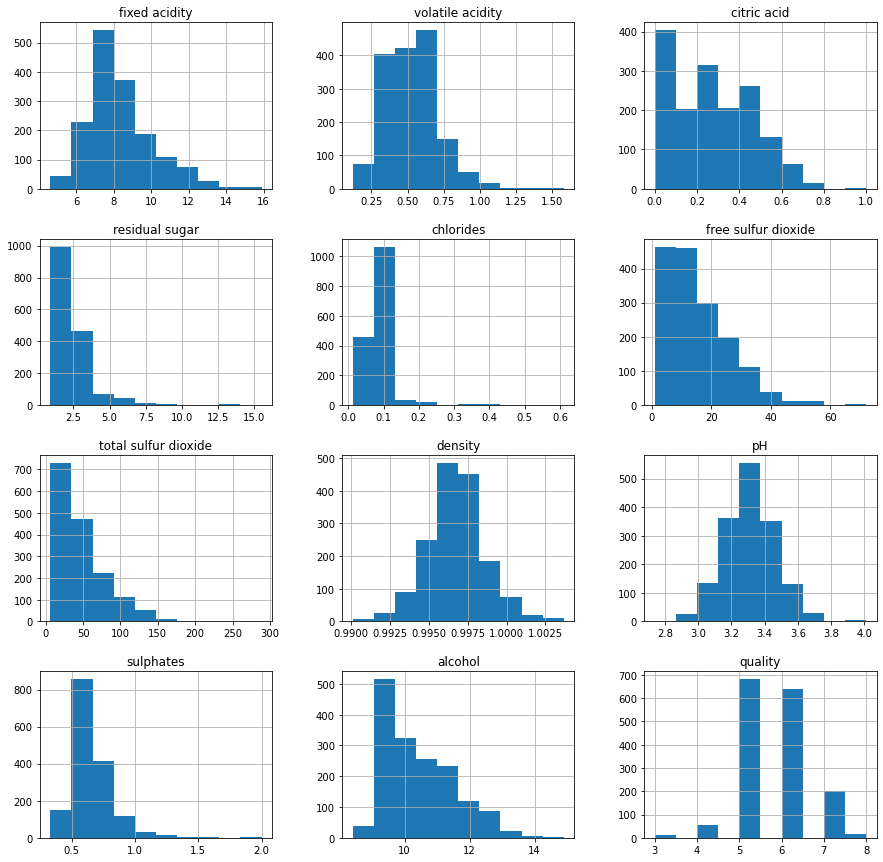

In [198]:
df_red.hist(figsize = (15,15))

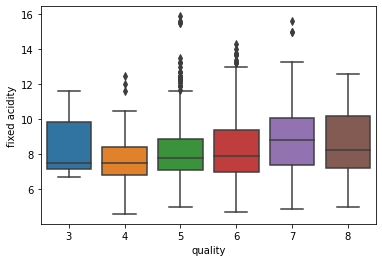

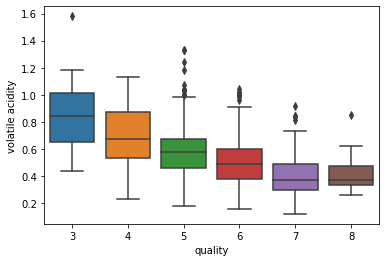

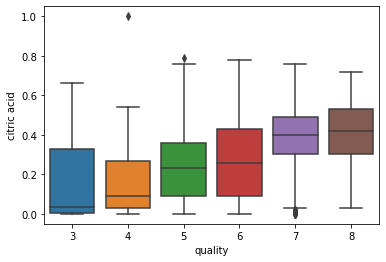

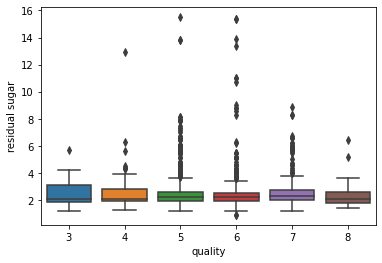

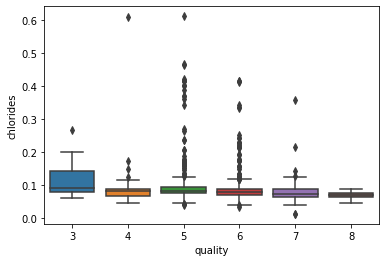

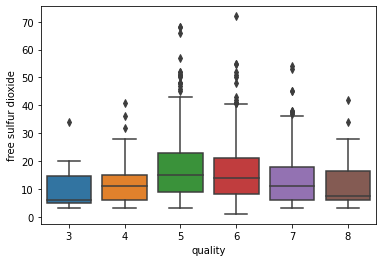

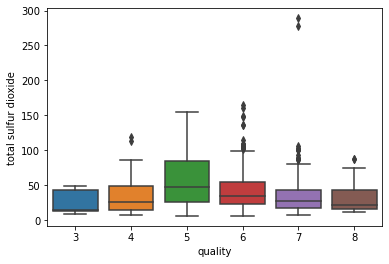

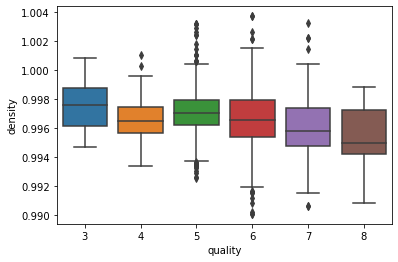

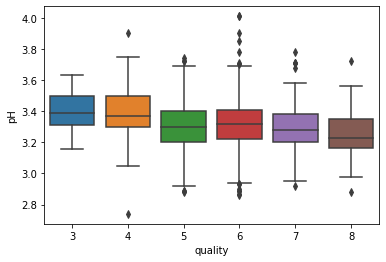

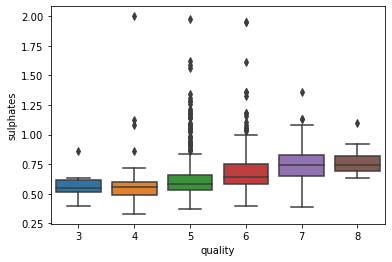

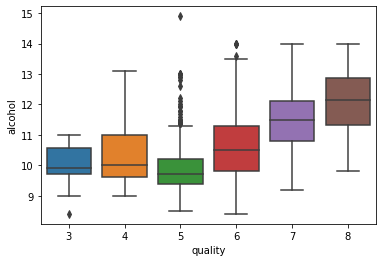

In [199]:
features = df_red.columns
for i in range(1,12):
    sns.boxplot(x='quality', y=features[i-1], data=df_red)
    plt.show()

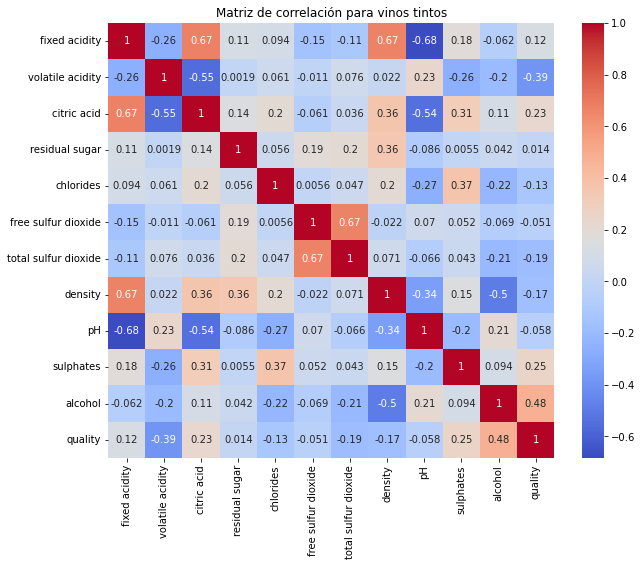

In [200]:
plt.figure(figsize=(10, 8))
correlation_red = df_red.corr()
sns.heatmap(correlation_red, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación para vinos tintos")
plt.show()

# Preprocesamiento de datos

En esta sección se realiza el preproceso de los datos. Primero se utiliza una función para categorizar la calidad de los vinos, siendo bajo un 5 de baja calidad, un 5 de calidad regular o prmedio y sobre 5 de alta calidad. Luego, se codifican las etiquetas de calidad para finalmente, mostrar en un gráfico Plot la distriuciond e la calidad de los vinos.

Para el oversampleo, el código realiza un bucle sobre las clases minoritarias y, en cada iteración, selecciona aleatoriamente una muestra de la clase minoritaria actual con un tamaño igual al de la clase mayoritaria. Esto se hace para abordar el desequilibrio de clases en el conjunto de datos, generando muestras sintéticas de la clase minoritaria para igualar la cantidad de muestras de la clase mayoritaria. Finalmente, todas las muestras sobremuestreadas se concatenan en un único DataFrame llamado **oversampled_data.** Luego, en **"oversampled_data = pd.concat([oversampled_data, majority_data])"** se combinan los datos sobremuestreados con los datos de la clase mayoritaria, creando así un único DataFrame que representa el conjunto de datos final con el desequilibrio de clases abordado. Luego se mezclan aleatoriamente las filas de **oversampled_data** y se crea un nuevo DatFrame llamado **oversampled_redwine_df.**

Luego, se calcula la proporción de cada valor de calidad en el DataFrame **oversampled_data** y luego visualiza la distribución de la calidad de los vinos tintos en el DataFrame **oversampled_redwine_df** mediante un gráfico de barras.

Luego se separan las características de las etiquetas y se escalan apra su posterior entrenamiento.

In [201]:
# Función para categorizar la calidad
def categorize_quality(quality):
    if quality < 5:
        return 'LowQuality'
    elif quality == 5:
        return 'Average'
    else:
        return 'HighQuality'

In [202]:
# Aplicamos la función a los datasets
df_red['quality'] = df_red['quality'].apply(categorize_quality)

In [203]:
# Codificando las etiquetas
le = LabelEncoder()
df_red['quality'] = le.fit_transform(df_red['quality'])

1    53.470919
0    42.589118
2     3.939962
Name: quality, dtype: float64


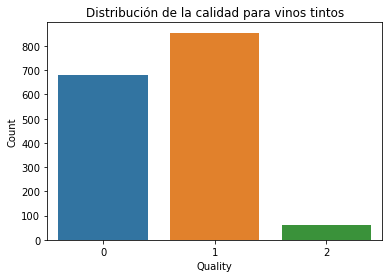

In [204]:
total_samples = len(df_red)
label_counts = df_red['quality'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df_red)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

In [205]:
minority_classes = [0,2]

In [206]:
minority_data = df_red[df_red['quality'].isin(minority_classes)]
majority_data = df_red[~df_red['quality'].isin(minority_classes)]

In [207]:
n_samples_majority = len(majority_data)

In [208]:
oversampled_data = pd.concat([
    minority_data[minority_data['quality'] == cls].sample(
        n=n_samples_majority, replace=True, random_state=42)
    for cls in minority_classes
])

In [209]:
oversampled_data = pd.concat([oversampled_data, majority_data])

In [210]:
oversampled_redwine_df = shuffle(oversampled_data, random_state=42)

0    33.333333
2    33.333333
1    33.333333
Name: quality, dtype: float64


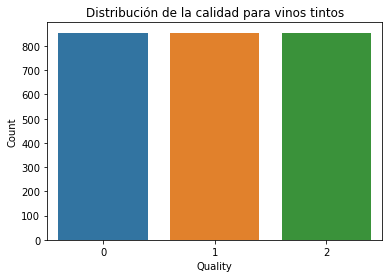

In [211]:
total_samples = len(oversampled_redwine_df)
label_counts = oversampled_data['quality'].value_counts()
label_proportions = label_counts / total_samples * 100
print(label_proportions)

# Distribución de la calidad
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=oversampled_redwine_df)
plt.title("Distribución de la calidad para vinos tintos")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

In [212]:
# Separando las características de las etiquetas
X_red = oversampled_redwine_df.drop('quality', axis=1)
y_red = oversampled_redwine_df['quality']

In [213]:
# Escalando las características
scaler = StandardScaler()
X_red = scaler.fit_transform(X_red)

In [214]:
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

# Modelo de clasificación con Red Neuronal (Función sigmoidal)

In [288]:
# Definir el procedimiento de k-fold cross validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

# Almacenar los puntajes de cada iteración
scores = []
accuracy = []
loss = []
val_loss = []
val_accuracy = []

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))

# Loop para cada fold
for train, test in kfold.split(X_red_np):
    # Crear el modelo
    model = keras.models.Sequential([
        keras.layers.Dense(256, activation="sigmoid",
                        input_shape=(X_red_np.shape[1],)),
        keras.layers.Dense(128, activation="sigmoid"),
        keras.layers.Dense(3, activation="softmax")
    ])

    # Compilar el modelo
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenar el modelo en los datos de entrenamiento
    cl = model.fit(X_red_np[train], y_red_np[train], epochs=100,
                   batch_size=32, verbose=0, validation_split=0.2)

    accuracy = cl.history['accuracy']
    loss = cl.history['loss']
    val_loss = cl.history['val_loss']
    val_accuracy = cl.history['val_accuracy']

    # Evaluar el modelo en los datos de prueba
    score = model.evaluate(X_red_np[test], y_red_np[test], verbose=0)
    scores.append(score[1])

# Calcular y imprimir el puntaje promedio
average_score = np.mean(scores)
print('Average score:', average_score)


Average score: 0.7189083814620971


17/17 [==============================] - 0s 875us/step


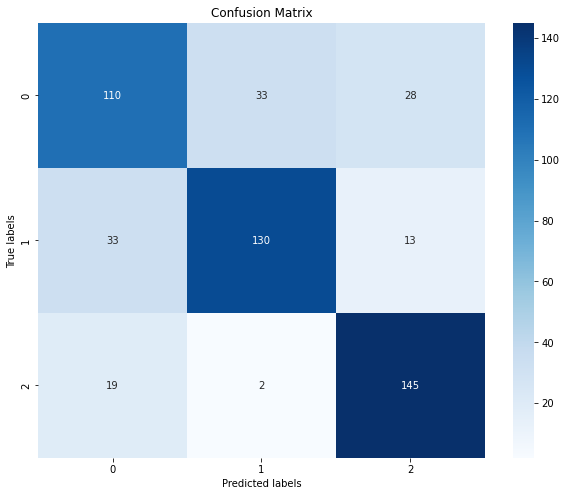

In [289]:
p_test = model.predict(X_red_test).argmax(axis=1)
cm = tf.math.confusion_matrix(y_red_test, p_test)

cm_array = cm.numpy()

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar la matriz de confusión
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', ax=ax)

# Configurar las etiquetas de los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Mostrar la figura
plt.show()

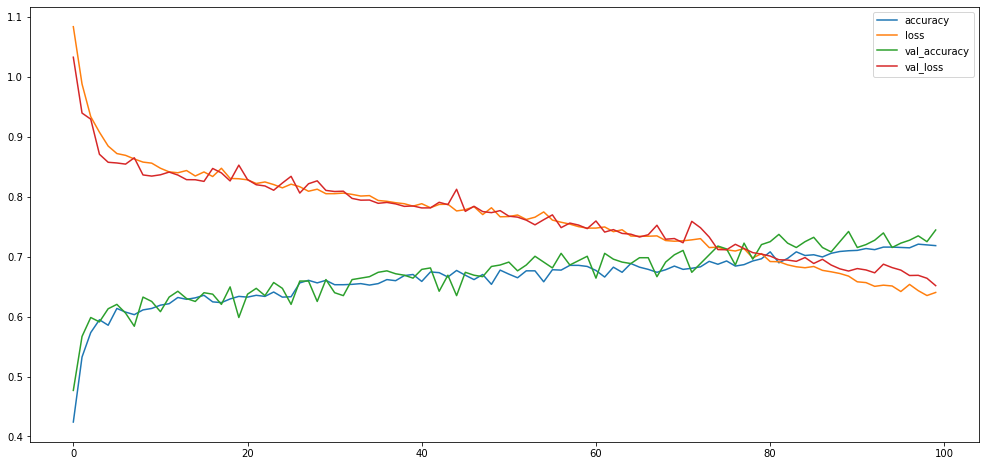

In [290]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(accuracy, label='accuracy')
plt.plot(loss,label='loss')
plt.plot(val_accuracy,label='val_accuracy')
plt.plot(val_loss,label='val_loss')
plt.legend()

# Modelo de clasificación con Red neuronal (Función tangente hiperbólica) 

In [284]:
# Definir el procedimiento de k-fold cross validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

# Almacenar los puntajes de cada iteración
scores = []
accuracy = []
loss = []
val_loss = []
val_accuracy = []

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))

# Loop para cada fold
for train, test in kfold.split(X_red_np):
    # Crear el modelo
    model = keras.models.Sequential([
        keras.layers.Dense(256, activation="tanh",input_shape=(X_red_np.shape[1],)),
        keras.layers.Dense(128, activation="tanh"),
        keras.layers.Dense(3, activation="softmax")
    ])

    # Compilar el modelo
    model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
    # Entrenar el modelo en los datos de entrenamiento
    cl = model.fit(X_red_np[train], y_red_np[train], epochs=100,
                   batch_size=32, verbose=0, validation_split=0.2)

    accuracy = cl.history['accuracy']
    loss = cl.history['loss']
    val_loss = cl.history['val_loss']
    val_accuracy = cl.history['val_accuracy']

    # Evaluar el modelo en los datos de prueba
    score = model.evaluate(X_red_np[test], y_red_np[test], verbose=0)
    scores.append(score[1])

# Calcular y imprimir el puntaje promedio
average_score = np.mean(scores)
print('Average score:', average_score)


Average score: 0.8939571142196655


17/17 [==============================] - 0s 938us/step


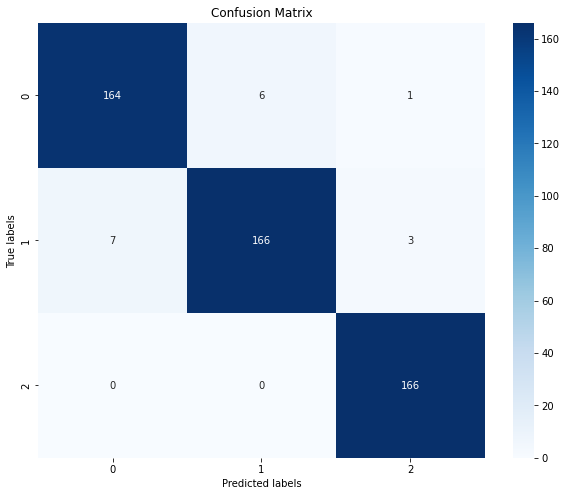

In [285]:
p_test = model.predict(X_red_test).argmax(axis=1)
cm = tf.math.confusion_matrix(y_red_test, p_test)

cm_array = cm.numpy()

# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))

# Graficar la matriz de confusión
sns.heatmap(cm_array, annot=True, cmap='Blues', fmt='d', ax=ax)

# Configurar las etiquetas de los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Mostrar la figura
plt.show()

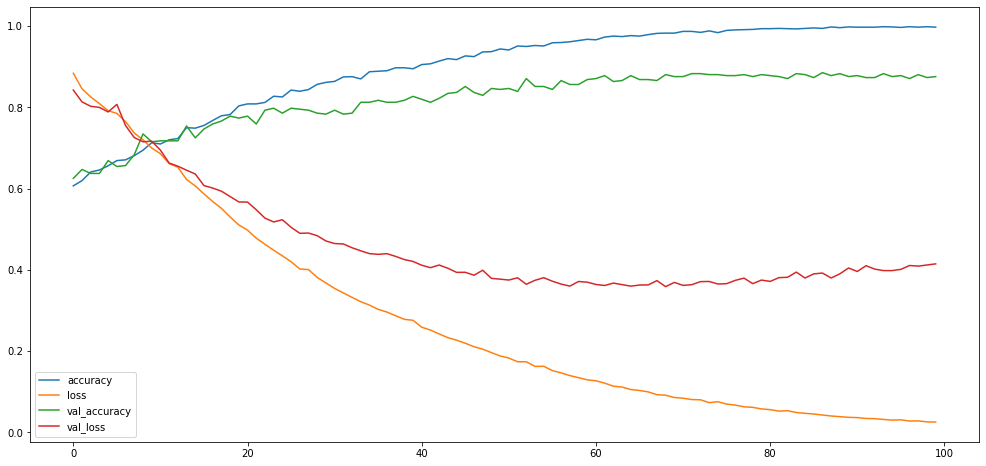

In [286]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(accuracy, label='accuracy')
plt.plot(loss,label='loss')
plt.plot(val_accuracy,label='val_accuracy')
plt.plot(val_loss,label='val_loss')
plt.legend()

# Modelo de regresión con Red Neuronal (Función sigmoidal)

In [346]:
X_red_regression = oversampled_redwine_df.drop('quality', axis=1)
y_red_regression = oversampled_redwine_df['quality']

In [357]:
# Definir el procedimiento de k-fold cross validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))

# Loop para cada fold
for train, test in kfold.split(X_red_np):
    # Crear el modelo
    model = keras.models.Sequential([
        keras.layers.Dense(256, activation="sigmoid",input_shape=(X_red_np.shape[1],)),
        keras.layers.Dense(128, activation="sigmoid"),
        keras.layers.Dense(1, activation="linear")
    ])

    # Compilar el modelo
    model.compile(optimizer='adam',
                loss='mse',
                metrics=['mse','mae'])
    
    # Entrenar el modelo en los datos de entrenamiento
    cl = model.fit(X_red_np[train], y_red_np[train], epochs=100,
                   batch_size=32, verbose=1, validation_split=0.2)

    # Evaluar el modelo en los datos de prueba
    score = model.evaluate(X_red_np[test], y_red_np[test], verbose=1)
    scores.append(score[1])

# Calcular y imprimir el puntaje promedio
average_score = np.mean(scores)
print('Average score:', average_score)


Epoch 1/100
52/52 [==============================] - 1s 4ms/step - loss: 0.2292 - mse: 0.2292 - mae: 0.4444 - val_loss: 0.2225 - val_mse: 0.2225 - val_mae: 0.4501
Epoch 2/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2223 - mse: 0.2223 - mae: 0.4445 - val_loss: 0.2222 - val_mse: 0.2222 - val_mae: 0.4447
Epoch 3/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2222 - mse: 0.2222 - mae: 0.4444 - val_loss: 0.2222 - val_mse: 0.2222 - val_mae: 0.4446
Epoch 4/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2222 - mse: 0.2222 - mae: 0.4444 - val_loss: 0.2222 - val_mse: 0.2222 - val_mae: 0.4443
Epoch 5/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2222 - mse: 0.2222 - mae: 0.4444 - val_loss: 0.2222 - val_mse: 0.2222 - val_mae: 0.4443
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.2222 - mse: 0.2222 - mae: 0.4444 - val_loss: 0.2222 - val_mse: 0.2222 - val_mae: 0.4445
Epoch 7/100
52/52 [===

KeyboardInterrupt: 

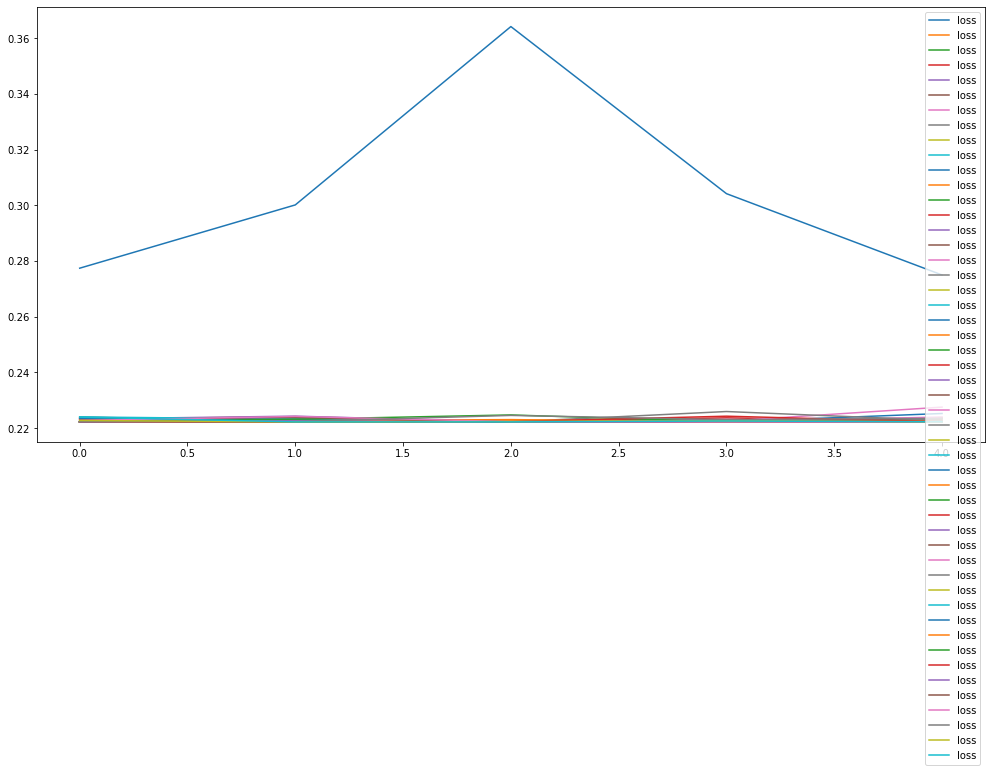

In [345]:
fig, ax = plt.subplots(figsize=(17,8))

plt.plot(loss, label='loss')

plt.legend()

# Modelo de regresión con Red Neuronal (Función tangente hiperbólica)

In [331]:
# Definir el modelo
def create_tanh_model():
    model = keras.models.Sequential([
        keras.layers.Dense(32, activation="tanh",input_shape=(X_red_np.shape[1],)),
        keras.layers.Dense(16, activation="tanh"),
        keras.layers.Dense(1,activation="softmax")
    ])
    
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
    
    return model

In [332]:
# Definir el procedimiento de k-fold cross validation
k = 5
kfold = KFold(n_splits=k, shuffle=True, random_state=1)

# Almacenar los puntajes de cada iteración
scores = []
accuracy = []
loss = []
val_loss = []
val_accuracy = []

# Convertir a arrays de NumPy
X_red_np = np.array(X_red)
y_red_np = keras.utils.to_categorical(np.array(y_red))
errors = []

for train, test in kfold.split(X_red_np):
        model = create_tanh_model()
        cl = model.fit(X_red_np[train], y_red_np[train], epochs=100, verbose=1,validation_split=0.2)
        error = model.evaluate(X_red_np[test], y_red_np[test], verbose=1)
        errors.append(error)

        accuracy = cl.history['accuracy']
        loss = cl.history['loss']
        val_loss = cl.history['val_loss']
        val_accuracy = cl.history['val_accuracy']

print(f'Mean Squared Error: {np.mean(errors)}')

Epoch 1/100
52/52 [==============================] - 1s 3ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 2/100
52/52 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 3/100
52/52 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 4/100
52/52 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 5/100
52/52 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 6/100
52/52 [==============================] - 0s 2ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 7/100
52/52 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.3333 - val_loss: 0.6667 - val_accuracy: 0.3333
Epoch 8/100
5

# Comparación de resultados